In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
dfs = {
    'patients':       pd.read_csv('mimic-iii-clinical-database-demo-1.4\\PATIENTS.csv'),
    'transfers':      pd.read_csv('mimic-iii-clinical-database-demo-1.4\\TRANSFERS.csv'),
    'prescriptions':  pd.read_csv('mimic-iii-clinical-database-demo-1.4\\PRESCRIPTIONS.csv'),
    'microbio':       pd.read_csv('mimic-iii-clinical-database-demo-1.4\\MICROBIOLOGYEVENTS.csv'),
    'drg':            pd.read_csv('mimic-iii-clinical-database-demo-1.4\\DRGCODES.csv'),
    'caregivers':     pd.read_csv('mimic-iii-clinical-database-demo-1.4\\CAREGIVERS.csv')
}

In [4]:
for name, df in dfs.items():
    df.columns = df.columns.str.lower()

patients = dfs['patients']
transfers = dfs['transfers']
presc = dfs['prescriptions']
micro = dfs['microbio']
drg = dfs['drg']
care = dfs['caregivers']

In [5]:
transfers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row_id         524 non-null    int64  
 1   subject_id     524 non-null    int64  
 2   hadm_id        524 non-null    int64  
 3   icustay_id     167 non-null    float64
 4   dbsource       524 non-null    object 
 5   eventtype      524 non-null    object 
 6   prev_careunit  167 non-null    object 
 7   curr_careunit  167 non-null    object 
 8   prev_wardid    395 non-null    float64
 9   curr_wardid    395 non-null    float64
 10  intime         524 non-null    object 
 11  outtime        395 non-null    object 
 12  los            395 non-null    float64
dtypes: float64(4), int64(3), object(6)
memory usage: 53.3+ KB


In [6]:
def calc_age(row):
    dob = datetime.strptime(row['dob'], "%Y-%m-%d %H:%M:%S")
    dod = datetime.strptime(row['dod'], "%Y-%m-%d %H:%M:%S")
    return (dod - dob).days // 365

patients['age'] = patients.apply(calc_age, axis=1)
patients = patients[patients['age'] < 120]

C:\Users\aaron\AppData\Local\Temp\ipykernel_37012\1529028979.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transfers['duration_hr'] = (transfers['outtime'] - transfers['intime']).dt.total_seconds() / 3600


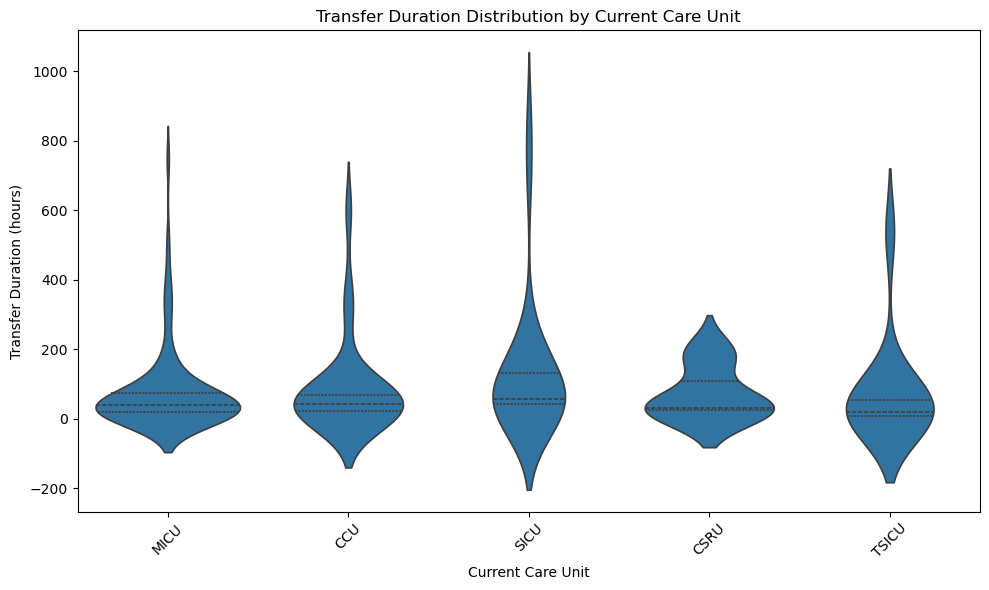

In [7]:
transfers['intime']  = pd.to_datetime(transfers['intime'])
transfers['outtime'] = pd.to_datetime(transfers['outtime'])

transfers = transfers.dropna(subset=['outtime', 'curr_careunit'])
transfers['duration_hr'] = (transfers['outtime'] - transfers['intime']).dt.total_seconds() / 3600

plt.figure(figsize=(10,6))
sns.violinplot(
    data=transfers,
    x='curr_careunit',
    y='duration_hr',
    inner='quartile'
)
plt.title('Transfer Duration Distribution by Current Care Unit')
plt.xlabel('Current Care Unit')
plt.ylabel('Transfer Duration (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\aaron\AppData\Local\Temp\ipykernel_37012\924421530.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_meds.values, y=top_meds.index, palette='magma')


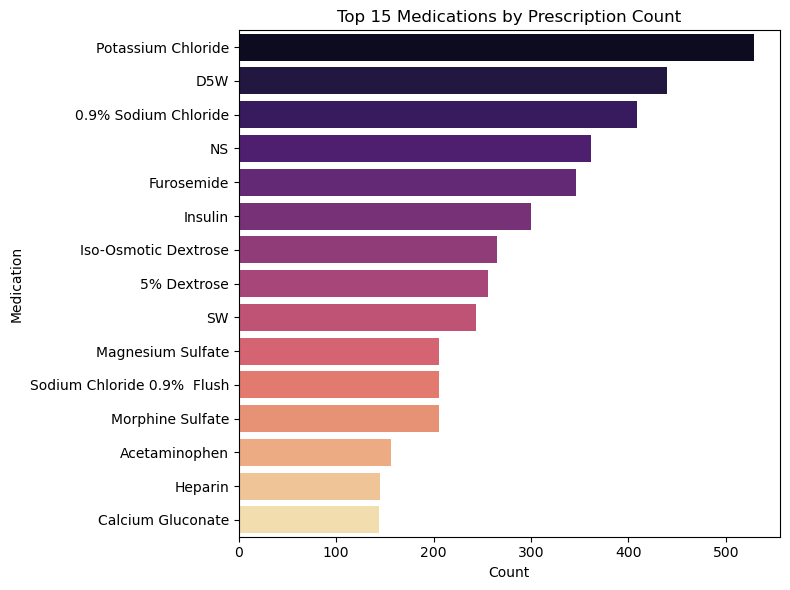

In [8]:
top_meds = presc['drug'].value_counts().nlargest(15)
plt.figure(figsize=(8,6))
sns.barplot(x=top_meds.values, y=top_meds.index, palette='magma')
plt.title('Top 15 Medications by Prescription Count')
plt.xlabel('Count')
plt.ylabel('Medication')
plt.tight_layout()
plt.show()

In [9]:
micro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2003 entries, 0 to 2002
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   row_id               2003 non-null   int64  
 1   subject_id           2003 non-null   int64  
 2   hadm_id              2003 non-null   int64  
 3   chartdate            2003 non-null   object 
 4   charttime            1912 non-null   object 
 5   spec_itemid          2003 non-null   int64  
 6   spec_type_desc       2003 non-null   object 
 7   org_itemid           1137 non-null   float64
 8   org_name             1137 non-null   object 
 9   isolate_num          1137 non-null   float64
 10  ab_itemid            971 non-null    float64
 11  ab_name              971 non-null    object 
 12  dilution_text        939 non-null    object 
 13  dilution_comparison  938 non-null    object 
 14  dilution_value       938 non-null    float64
 15  interpretation       971 non-null    o

In [10]:
import plotly.express as px
m = micro.dropna(subset=['org_name'])
top_orgs  = m['org_name'].value_counts().nlargest(10).index
top_specs = m['spec_type_desc'].value_counts().nlargest(8).index
subm = m[m['org_name'].isin(top_orgs) & m['spec_type_desc'].isin(top_specs)]
heat = pd.crosstab(subm['spec_type_desc'], subm['org_name'])

fig_ht = px.imshow(
    heat,
    x=heat.columns,
    y=heat.index,
    labels={'x':'Organism','y':'Specimen Type','color':'Count'},
    title='Counts of Top Organisms by Specimen Type'
)
fig_ht.update_xaxes(tickangle=45)
fig_ht.write_html("heatmap.html")
fig_ht.show()

In [18]:
care.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7567 entries, 0 to 7566
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   row_id       7567 non-null   int64 
 1   cgid         7567 non-null   int64 
 2   label        7518 non-null   object
 3   description  5155 non-null   object
dtypes: int64(2), object(2)
memory usage: 236.6+ KB


In [16]:
c = care.dropna(subset=['label'])
top_labels = c['label'].value_counts().nlargest(10)
fig_pie = px.pie(
    names=top_labels.index,
    values=top_labels.values,
    hole=0.4,
    title='Top 10 Caregiver Labels by Assignment Count'
)
fig_pie.update_traces(textposition='inside', textinfo='percent+label')
fig_pie.show()
fig_pie.write_html("labels.html")

In [11]:
drg.info

<bound method DataFrame.info of      row_id  subject_id  hadm_id drg_type  drg_code  \
0      1338       10130   156668     HCFA       148   
1      2188       10114   167957     HCFA       518   
2      2599       10117   187023     HCFA       185   
3      2703       10046   133110     HCFA         1   
4      3020       10011   105331     HCFA       205   
..      ...         ...      ...      ...       ...   
292  125347       41976   149469     APR       7204   
293  125348       41976   149469     APR       7204   
294  125442       41976   153826     APR       7204   
295  125443       41976   153826     APR       7204   
296  125444       41976   153826       MS       871   

                                           description  drg_severity  \
0    MAJOR SMALL & LARGE BOWEL PROCEDURES WITH COMP...           NaN   
1    PERCUTANEOUS CARDIOVASCULAR PROCEDURES WITHOUT...           NaN   
2    DENTAL & ORAL DIS EXCEPT EXTRACTIONS & RESTORA...           NaN   
3                 C

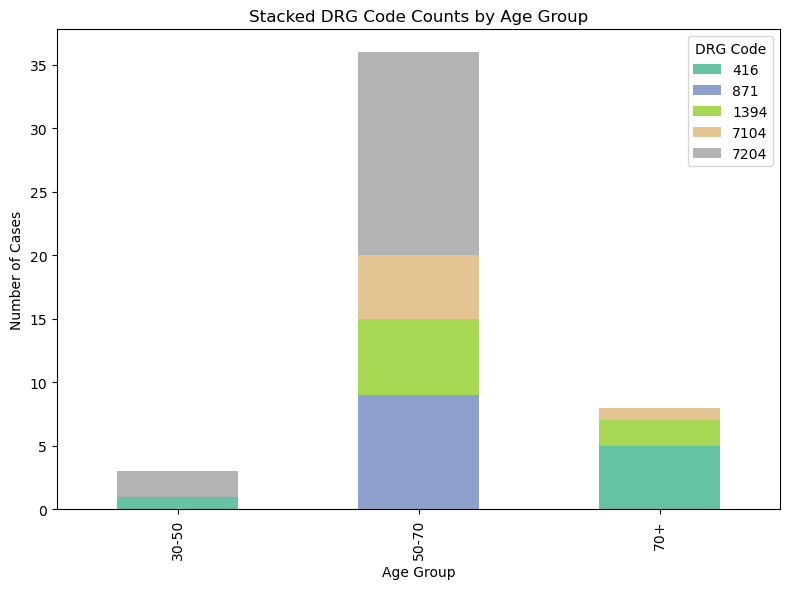

In [ ]:

drg = drg.merge(patients[['subject_id','age']], on='subject_id', how='inner')
# bin ages
bins = [0, 30, 50, 70, 120]
labels = ['<30','30-50','50-70','70+']
drg['age_group'] = pd.cut(drg['age'], bins=bins, labels=labels)

# count most common DRG codes
top_drg = drg['drg_code'].value_counts().nlargest(5).index
subset = drg[drg['drg_code'].isin(top_drg)]
ct = pd.crosstab(subset['age_group'], subset['drg_code'])

ct.plot(kind='bar', stacked=True, figsize=(8,6), colormap='Set2')
plt.title('Stacked DRG Code Counts by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Cases')
plt.legend(title='DRG Code')
plt.tight_layout()
plt.show()